# Evaluation

This Notebook contains the evaluation of all used machine learning models during this project. \
Evaluation and Validation will be performed on the test and validation data 

In [2]:
# Imports 
import numpy as np
import sys
sys.path.append("..")
import pandas as pd 
import matplotlib.pyplot as plt
from model.helpers import *
from model.predict import *
from collections import defaultdict
from sklearn.metrics import (
    roc_curve, auc, 
    precision_score,
    roc_auc_score,
    recall_score,
    f1_score)

from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
import warnings  
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)

In [3]:
#load data 
TRAIN = {}
TEST = {}
VALIDATION = {}

path = "../../data/interim/"
train = "train_"
test = "test_"
validation = "validation_"
#  list of scenarios
scenarios = [
        'CVE-2012-2122',
        'CVE-2014-0160',
        'CVE-2017-7529',
        'CVE-2017-12635_6',
        'CVE-2018-3760',
        'CVE-2019-5418',
        'CVE-2020-9484',
        'CVE-2020-13942',
        'CVE-2020-23839',
        'CWE-89-SQL-injection'
]

for i in range(0,len(scenarios)):
    TRAIN[scenarios[i]]= pd.read_pickle(path + "/" + train + scenarios[i] + ".pkl")
    TEST[scenarios[i]] = pd.read_pickle(path + "/" + test + scenarios[i] + ".pkl")
    VALIDATION[scenarios[i]] = pd.read_pickle(path + "/" + validation + scenarios[i] + ".pkl")
            

In [4]:
# load each model for each Scenario

model_type ='IsolationForest'
IsoForests = {}
for i in range(0, len(scenarios)):
# get dict and save mofel for each scenario
    IsoForests[scenarios[i]] = load_model(model_type=model_type, data=TRAIN, scenario=scenarios[i])

model_type ='LocalOutlierFactor'
lof_ = {}
for i in range(0, len(scenarios)):
# get dict and save mofel for each scenario
    lof_[scenarios[i]] = load_model(model_type=model_type, data=TRAIN, scenario=scenarios[i])


In [5]:
# get true values to evaluate algorithm
y_true = {}
for i in range(0, len(scenarios)):
    y_true[scenarios[i]] = encode(TEST[scenarios[i]])['exploit'] # remember 0 = inliners, 1 = outliers
    # encode to fit Isolation Forest predicitons 
    y_true[scenarios[i]] = y_true[scenarios[i]].mask(y_true[scenarios[i]]==1, -1) # now # remember -1 outliers
    y_true[scenarios[i]]  = y_true[scenarios[i]].mask(y_true[scenarios[i]]==0,  1) # 1 = inliners
 

IsolationForest: Best Threshold -0.100590
LocalOutlierFactor: Best Threshold -0.045562


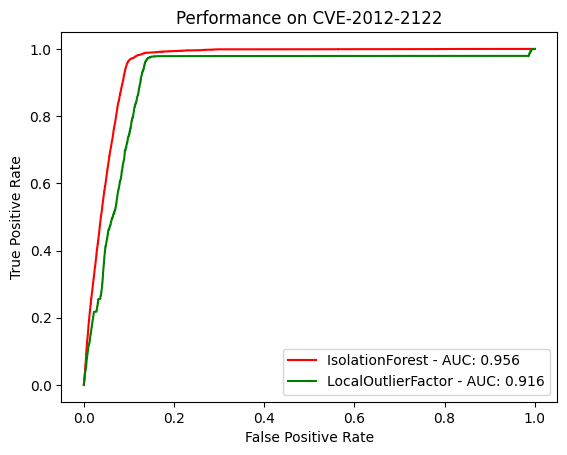

IsolationForest: Best Threshold 0.028567
LocalOutlierFactor: Best Threshold 0.244988


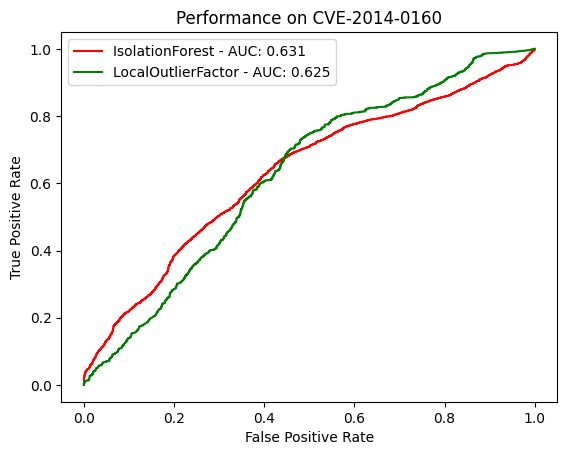

IsolationForest: Best Threshold 0.171387
LocalOutlierFactor: Best Threshold 0.500000


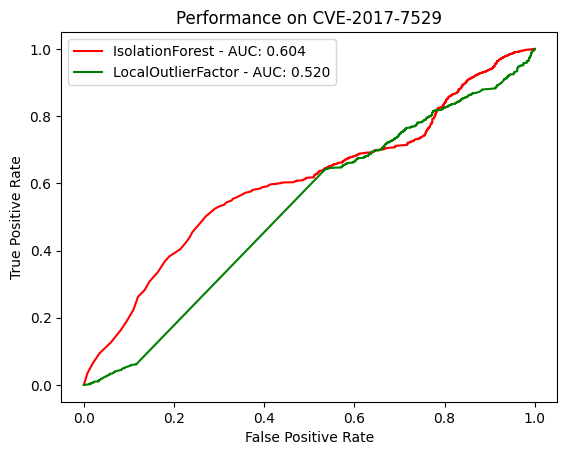

IsolationForest: Best Threshold 0.011904
LocalOutlierFactor: Best Threshold 0.500000


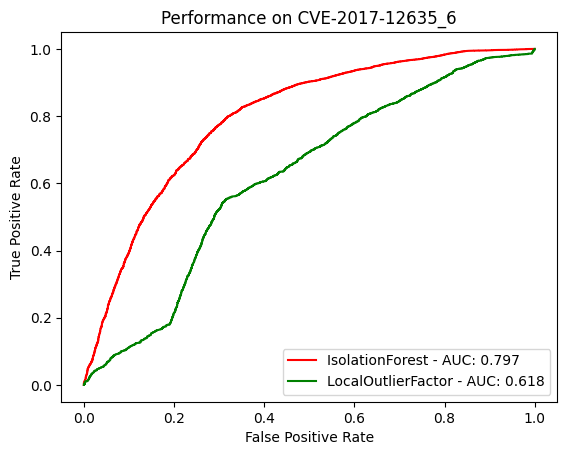

IsolationForest: Best Threshold 0.064761
LocalOutlierFactor: Best Threshold -16069.140709


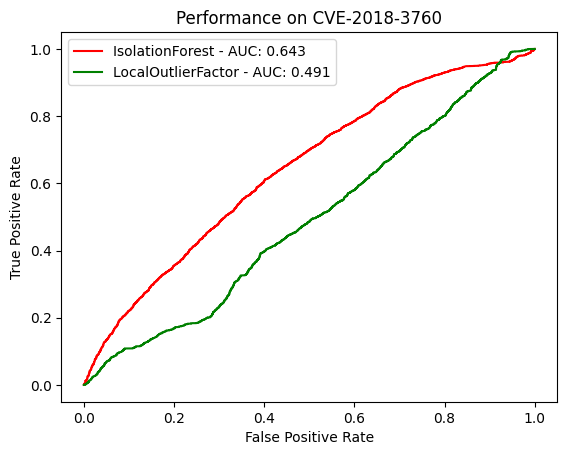

IsolationForest: Best Threshold 0.095718
LocalOutlierFactor: Best Threshold -156.492048


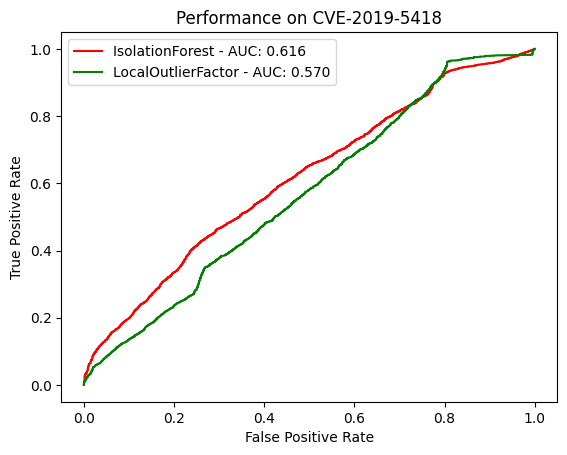

IsolationForest: Best Threshold 0.114613
LocalOutlierFactor: Best Threshold 0.513768


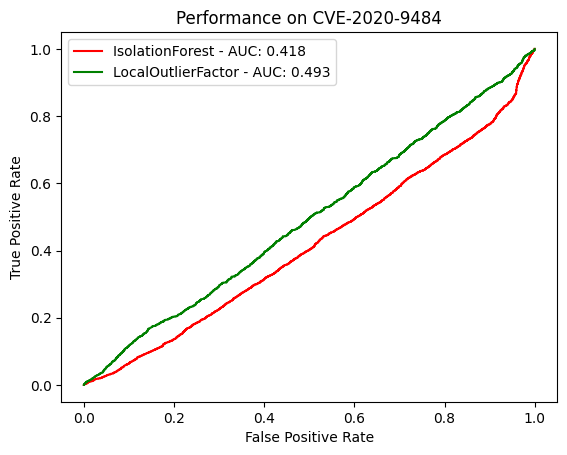

IsolationForest: Best Threshold 0.105527
LocalOutlierFactor: Best Threshold 0.506313


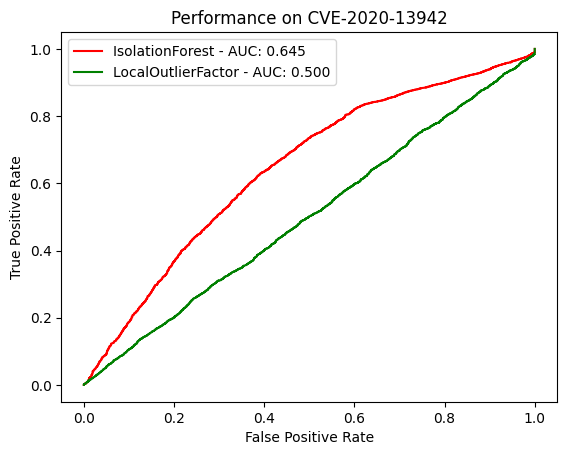

IsolationForest: Best Threshold 0.001485
LocalOutlierFactor: Best Threshold 0.364141


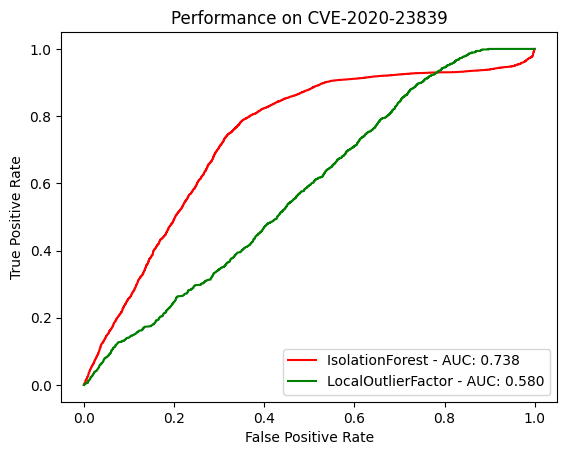

IsolationForest: Best Threshold 0.043390
LocalOutlierFactor: Best Threshold 0.319802


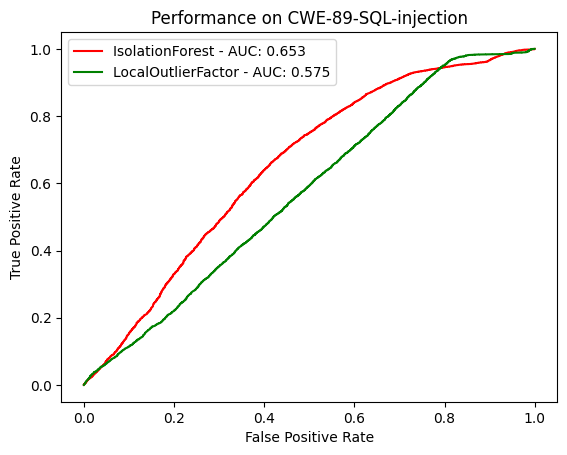

In [6]:
name = ['IsolationForest',  'LocalOutlierFactor']
colors = ['red', 'green']
# Create plots for all scenarios 
for i in range(0,len(scenarios)):
   #scenario = "CVE-2012-2122" 
   # prepare test data 
   X_test = TEST[scenarios[i]]
   X_test = select_columns_for_modelling(X_test)

   algorithms = [ IsoForests[scenarios[i]], lof_[scenarios[i]] ] 
  

   fig = plt.figure()
   for a, algo in enumerate(algorithms):
      algo_test = algo.decision_function(X_test)
   
      fpr_test_, tpr_test_, thresholds = roc_curve(y_true[scenarios[i]], algo_test) # Kommt drauf an wie rum(?) nochmal genau reinschauen 
      algo_auc_test = auc(fpr_test_, tpr_test_)
      J = tpr_test_ - fpr_test_
      ix = np.argmax(J)
      best_thresh = thresholds[ix]
      print(str(name[a]) + ': Best Threshold %f' % (best_thresh))


      
      plt.subplot(1, 1, 1)
      plt.title('Performance on ' + scenarios[i])
      plt.plot(fpr_test_, tpr_test_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_test)) #AMV: Augmented Mass Volume Function # AUC ohne 1
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      


   plt.subplot(1, 1, 1)
   plt.legend(loc=0)
   plt.xlim((-0.05, 1.05))
   plt.ylim((-0.05, 1.05))

   plt.show()
   fig.savefig("../../src/plots/models/EVALUATION_ALLMODELS_" + scenarios[i] + ".png")

In [7]:
scores = {}
for h in range(0, len(scenarios)):
    X_test = TEST[scenarios[h]]
    X_test = select_columns_for_modelling(X_test)
    algorithms = [(IsoForests[scenarios[h]], 'IsolationForest'),(lof_[scenarios[h]],'LocalOutlierFactor')]

    dict_ = {scenarios[h] : defaultdict(list)}
    scores.update(dict_)
    for i, (algo, name) in enumerate(algorithms):
        scores[scenarios[h]]["Algorithm"].append(name)
        y_prediction = algo.predict(X_test)

        for metric in [precision_score, recall_score, f1_score, roc_auc_score]:
            score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
            scores[scenarios[h]][score_name].append(metric(y_true[scenarios[h]], y_prediction))

        score_df = pd.DataFrame(scores[scenarios[h]]).set_index("Algorithm")
        #score_df["Scenario"] = scenarios[h]
        #score_df.round(decimals=3)
score_df


,Precision,Recall,F1,Roc auc
Algorithm,,,,
IsolationForest,0.918993,0.834075,0.874478,0.619393
LocalOutlierFactor,0.903778,0.977772,0.939320,0.567449


### Evaluation after Outlier Truncation

Outliers will be truncated using the Interquartile Range (IQR)

In [8]:
no_outliers = {}
for i in range(0,len(scenarios)):
    normal = TEST[scenarios[i]][TEST[scenarios[i]]['exploit']==False]
    attack = TEST[scenarios[i]][TEST[scenarios[i]]['exploit']!=False]
    # chose only cpu_usage and memory_usage
    normal = select_columns_outlier_truncate(normal)
    attack = select_columns_outlier_truncate(attack)
    # calculate IQR for each scenario
    Q1 = normal.quantile(0.25)
    Q3 = normal.quantile(0.75)
    IQR = Q3 - Q1
    normal = normal[~((normal< (Q1 - 1.5 * IQR)) |(normal > (Q3 + 1.5 * IQR))).any(axis=1)]
    no_outliers[scenarios[i]] = pd.concat([normal, attack])


In [9]:
# get all scenarios in one data set at the end
no_outliers_test = []
for key in no_outliers.keys():
    no_outliers[key]['scenario'] = key
    temp_df = no_outliers[key]
    no_outliers_test.append(temp_df)
no_outliers['ALL'] = pd.concat(no_outliers_test)

In [10]:
# get true values to evaluate algorithm
y_true = {}
for i in range(0, len(scenarios)):
    y_true[scenarios[i]] = encode(no_outliers[scenarios[i]])['exploit'] # remember 0 = inliners, 1 = outliers
    # encode to fit Isolation Forest predicitons 
    y_true[scenarios[i]] = y_true[scenarios[i]].mask(y_true[scenarios[i]]==1, -1) # now # remember -1 outliers
    y_true[scenarios[i]]  = y_true[scenarios[i]].mask(y_true[scenarios[i]]==0,  1) # 1 = inliners
 

IsolationForest: Best Threshold -0.093081
LocalOutlierFactor: Best Threshold -0.045562


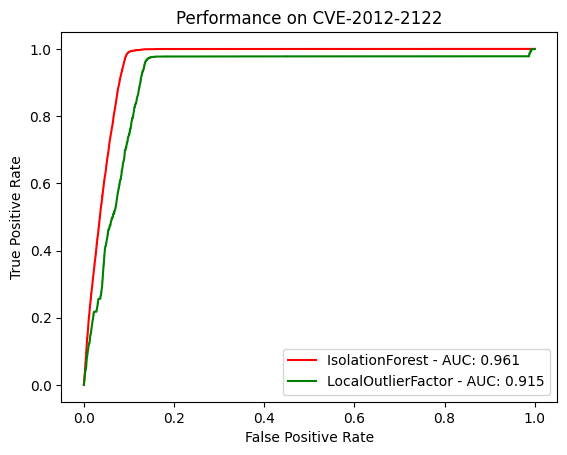

IsolationForest: Best Threshold 0.025512
LocalOutlierFactor: Best Threshold 0.244988


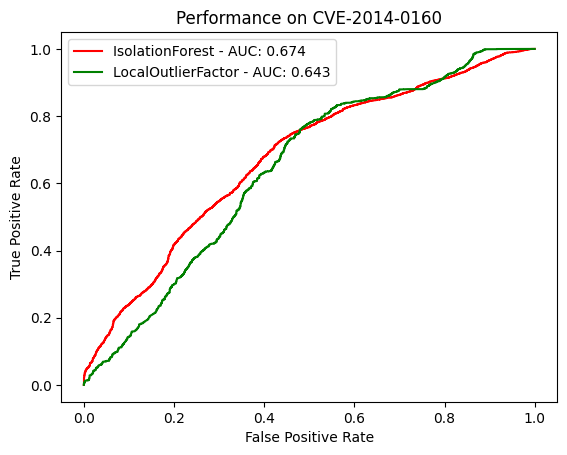

IsolationForest: Best Threshold 0.161923
LocalOutlierFactor: Best Threshold 0.500000


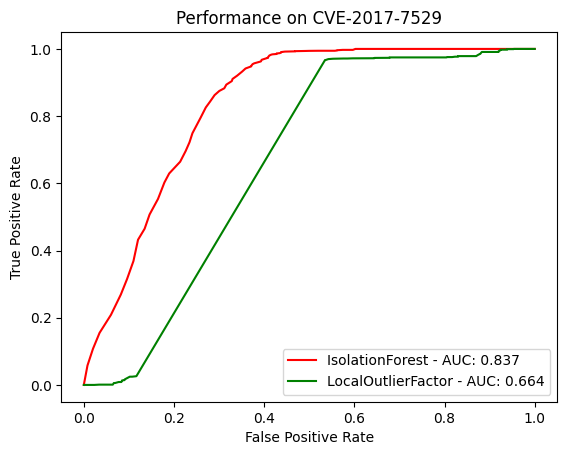

IsolationForest: Best Threshold 0.011904
LocalOutlierFactor: Best Threshold 0.500000


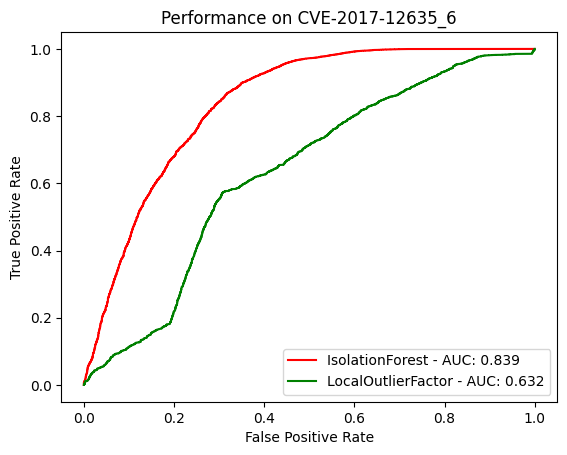

IsolationForest: Best Threshold 0.033121
LocalOutlierFactor: Best Threshold -0.174914


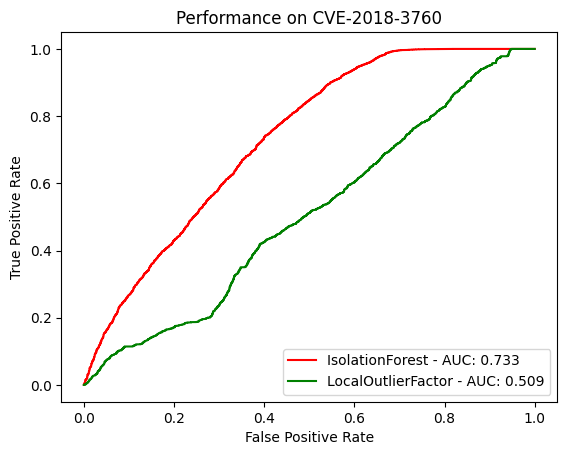

IsolationForest: Best Threshold 0.068848
LocalOutlierFactor: Best Threshold -0.485411


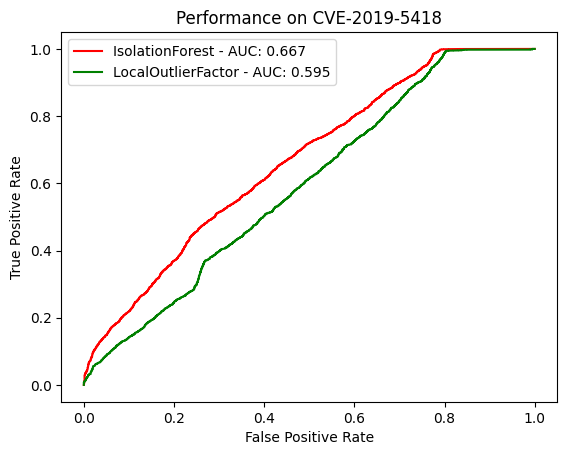

IsolationForest: Best Threshold -0.017622
LocalOutlierFactor: Best Threshold 0.513768


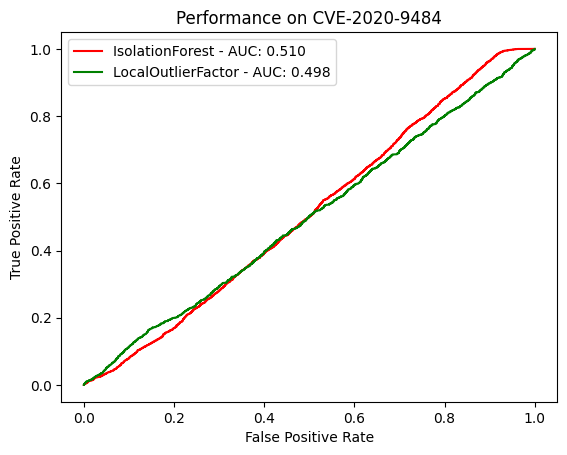

IsolationForest: Best Threshold 0.086906
LocalOutlierFactor: Best Threshold 0.506314


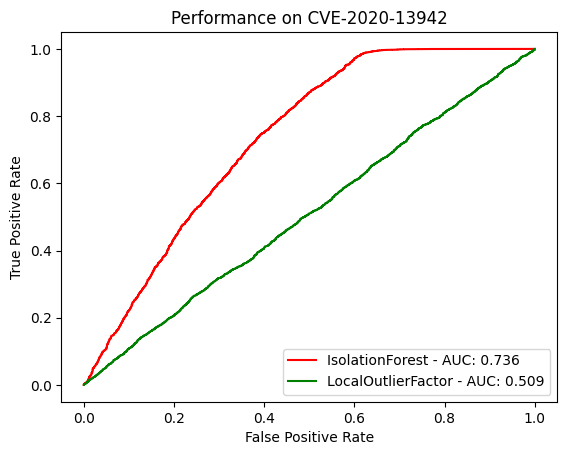

IsolationForest: Best Threshold -0.000223
LocalOutlierFactor: Best Threshold 0.364141


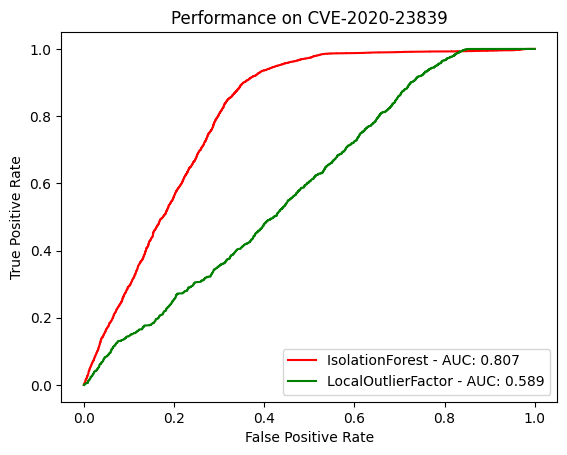

IsolationForest: Best Threshold 0.043390
LocalOutlierFactor: Best Threshold 0.319802


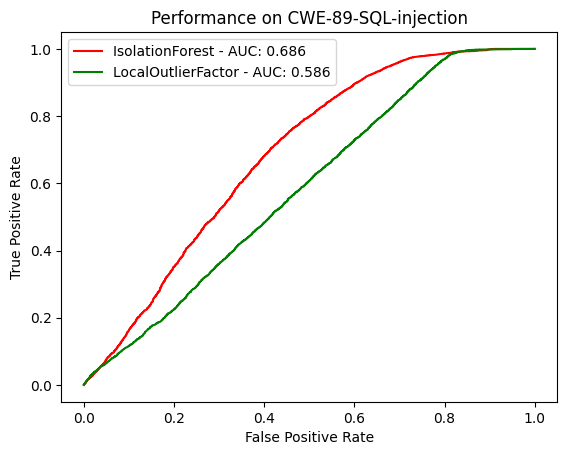

In [11]:
name = ['IsolationForest',  'LocalOutlierFactor']
colors = ['red', 'green']
# Create plots for all scenarios 
for i in range(0,len(scenarios)):
   #scenario = "CVE-2012-2122" 
   # prepare test data 
   X_test = no_outliers[scenarios[i]]
   X_test = select_columns_for_modelling(X_test)

   algorithms = [ IsoForests[scenarios[i]], lof_[scenarios[i]] ] 
  

   fig = plt.figure()
   for a, algo in enumerate(algorithms):
      algo_test = algo.decision_function(X_test)
   
      fpr_test_, tpr_test_, thresholds = roc_curve(y_true[scenarios[i]], algo_test) # Kommt drauf an wie rum(?) nochmal genau reinschauen 
      algo_auc_test = auc(fpr_test_, tpr_test_)
      J = tpr_test_ - fpr_test_
      ix = np.argmax(J)
      best_thresh = thresholds[ix]
      print(str(name[a]) + ': Best Threshold %f' % (best_thresh))


      
      plt.subplot(1, 1, 1)
      plt.title('Performance on ' + scenarios[i])
      plt.plot(fpr_test_, tpr_test_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_test)) #AMV: Augmented Mass Volume Function # AUC ohne 1
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      


   plt.subplot(1, 1, 1)
   plt.legend(loc=0)
   plt.xlim((-0.05, 1.05))
   plt.ylim((-0.05, 1.05))

   plt.show()
   fig.savefig("../../src/plots/models/EVALUATION_ALLMODELS_NO_OUTLIERS" + scenarios[i] + ".png")

In [13]:
threshold_dict

{'CWE-89-SQL-injection': defaultdict(list, {})}

In [12]:
# Sceanrio can be chosen dynamically
scores = {}
for h in range(0, len(scenarios)):
    X_test = no_outliers[scenarios[h]]
    X_test = select_columns_for_modelling(X_test)
    algorithms = [(IsoForests[scenarios[h]], 'IsolationForest'),(lof_[scenarios[h]],'LocalOutlierFactor')]

    dict_ = {scenarios[h] : defaultdict(list)}
    scores.update(dict_)
    for i, (algo, name) in enumerate(algorithms):
        scores[scenarios[h]]["Algorithm"].append(name)
        y_prediction = algo.predict(X_test)

        for metric in [precision_score, recall_score, f1_score, roc_auc_score]:
            score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
            scores[scenarios[h]][score_name].append(metric(y_true[scenarios[h]], y_prediction))

        score_df = pd.DataFrame(scores[scenarios[h]]).set_index("Algorithm")
        #score_df["Scenario"] = scenarios[h]
        #score_df.round(decimals=3)
score_df



,Precision,Recall,F1,Roc auc
Algorithm,,,,
IsolationForest,0.918993,0.888462,0.903470,0.646587
LocalOutlierFactor,0.899562,0.993151,0.944043,0.575138


### Evaluation after Threshold Adjustment